# XGBoost Model

This notebook demonstrates how to train and finetune an xgboost model on fingerprints generated from the rdkit chem package. Optimal parameters are explored using grid search from sklearn.

In [49]:
#Python standard libraries
import time
import warnings
from pathlib import Path
from warnings import filterwarnings
import time
import pandas as pd
import numpy as np

#creating deepcopy of model instances
from copy import deepcopy

#XGBoost library
import xgboost as xgb

#visualization
import seaborn as sns
import matplotlib.pyplot as plt

import torch

#save model
import pickle

#sklearn models and metric functions
from sklearn.model_selection import KFold, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import auc, accuracy_score, recall_score, roc_curve, precision_score
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score,confusion_matrix

#FP generators
from rdkit import Chem
from rdkit.Chem import MACCSkeys, rdFingerprintGenerator

#Silence some expected warnings
filterwarnings("ignore")

#Fix seed for reproducible results
SEED = 22
torch.manual_seed(SEED)


## XGBoost Model

In [2]:
#import train and test datasets
train = pd.read_csv("../models/SELFormer/data/EGFR_train.csv") 
test = pd.read_csv("../models/SELFormer/data/EGFR_valid.csv")

In [3]:
train.head()

,pIC50,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled,label,canonical_smiles
0,8.747147,522.168141,10,5,1.70260,True,1,COc1cc2c(Nc3ccc(F)c(Cl)c3)ncnc2cc1OCCCN1C[C@H]...
1,4.525347,344.142219,2,0,4.23280,True,0,CCCN(CCC)C(=O)c1ccc(N(CCCl)CCCl)cc1
2,6.000000,438.086160,7,2,5.03420,True,0,CCOC(=O)Nc1ccc(Nc2ncnc3cc(OC)c(OC)cc23)cc1Cl.Cl
3,8.795880,499.269573,8,2,4.50980,True,1,C=CC(=O)Nc1cc(Nc2cc(-c3cn(C)c4ccccc34)ncn2)c(O...
4,5.508638,271.030314,5,2,2.94918,True,0,N#C/C(=C\c1ccc(O)c(O)c1)C(=O)c1cccs1


In [4]:
# Keep only the columns we want
train = train[["canonical_smiles","molecular_weight", "n_hba","n_hbd","logp","label"]]
train.head()

,canonical_smiles,molecular_weight,n_hba,n_hbd,logp,label
0,COc1cc2c(Nc3ccc(F)c(Cl)c3)ncnc2cc1OCCCN1C[C@H]...,522.168141,10,5,1.70260,1
1,CCCN(CCC)C(=O)c1ccc(N(CCCl)CCCl)cc1,344.142219,2,0,4.23280,0
2,CCOC(=O)Nc1ccc(Nc2ncnc3cc(OC)c(OC)cc23)cc1Cl.Cl,438.086160,7,2,5.03420,0
3,C=CC(=O)Nc1cc(Nc2cc(-c3cn(C)c4ccccc34)ncn2)c(O...,499.269573,8,2,4.50980,1
4,N#C/C(=C\c1ccc(O)c(O)c1)C(=O)c1cccs1,271.030314,5,2,2.94918,0


In [5]:
def smiles_to_fp(smiles, method="maccs", n_bits=2048):
    """
    Encode a molecule from a SMILES string into a fingerprint.

    Parameters
    ----------
    smiles : str
        The SMILES string defining the molecule.

    method : str
        The type of fingerprint to use. Default is MACCS keys.

    n_bits : int
        The length of the fingerprint.

    Returns
    -------
    array
        The fingerprint array.

    """

    # convert smiles to RDKit mol object
    mol = Chem.MolFromSmiles(smiles)

    if method == "maccs":
        return np.array(MACCSkeys.GenMACCSKeys(mol))
    if method == "morgan2":
        fpg = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=n_bits)
        return np.array(fpg.GetFingerprint(mol))
    if method == "morgan3":
        fpg = rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=n_bits)
        return np.array(fpg.GetFingerprint(mol))
    else:
        # NBVAL_CHECK_OUTPUT
        print(f"Warning: Wrong method specified: {method}. Default will be used instead.")
        return np.array(MACCSkeys.GenMACCSKeys(mol))

In [6]:
#copy train df
compound_df = train.copy()

In [61]:
def crossvalidation(model_name, train_x, test_x, train_y, test_y, model_params, grid_params, iterable_parameter=np.nan):
    """
    Helper function to calculate model performance through crossvalidation.
    Updates model_results dictionary 

    Parameters
    ----------
    model_name: str
        Name of machine learning model to train.
    train_x: list
        Molecular fingerprints for train set.
    train_y: list
        Associated ground truth labels for train set.
    test_x: list
        Molecular fingerprints for test set.
    test_y: list
        Associated ground truth labels for test set.
    params: dict
        Parameters for XGB classifer
    iteratable_parameter:
        ....

    Returns
    -------
    None
    """

    #obtaining default parameters by calling .fit() to XGBoost model instance
    xgbc = xgb.XGBClassifier(**model_params) 
    xgbc.fit(train_x, train_y)

    #extracting parameters from last model
    gparams = xgbc.get_params()

    #GridSearch
    clf = GridSearchCV(estimator=xgbc, scoring='accuracy', param_grid=grid_params, return_train_score=True, verbose=1, cv=10)
    clf.fit(train_x, train_y)

    #results dataframe
    df = pd.DataFrame(clf.cv_results_)
    print(df)

    #predictions - inputs to confusion matrix
    train_predictions = clf.predict(train_x)
    test_predictions = clf.predict(test_x)

    #confusion matrices
    cfm_train = confusion_matrix(train_y, train_predictions)
    cfm_test = confusion_matrix(test_y, test_predictions)

    #accuracy scores
    accs_train = accuracy_score(train_y, train_predictions)
    accs_test = accuracy_score(test_y, test_predictions)

    #sensitivity scores
    sens_train = precision_score(train_y, train_predictions)
    sens_test = precision_score(test_y, test_predictions)

    #specificity scores
    spec_train = recall_score(train_y, train_predictions)
    spec_test = recall_score(test_y, test_predictions)

    #F1 scores for each train/test label
    f1s_train_p1 = f1_score(train_y, train_predictions, pos_label=1)
    f1s_train_p0 = f1_score(train_y, train_predictions, pos_label=0)
    f1s_test_p1 = f1_score(test_y, test_predictions, pos_label=1)
    f1s_test_p0 = f1_score(test_y, test_predictions, pos_label=0)

    #Area Under the Receiver Operating Characteristic Curve
    test_ras = roc_auc_score(test_y, clf.predict_proba(test_x)[:,1])

    #best parameters
    bp = clf.best_params_

    #storing computed values in results dictionary
    model_results[model_name] = {'iterable_parameter': iterable_parameter,
                            'classifier': deepcopy(xgbc),
                            'cv_results': df.copy(),
                            'cfm_train': cfm_train,
                            'cfm_test': cfm_test,
                            'default_params':gparams,
                            'train_accuracy': accs_train,
                            'test_accuracy': accs_test,
                            'train_sensitivity': sens_train,
                            'test_sensitivity': sens_test,
                            'train_specificity': spec_train,
                            'test_specificity': spec_test,
                            'train F1-score label 1': f1s_train_p1,
                            'train F1-score label 0': f1s_train_p0,
                            'test F1-score label 1': f1s_test_p1,
                            'test F1-score label 0': f1s_test_p0,
                            'test roc auc score': test_ras,
                            'best_params': bp}



In [8]:

def plots_for_model(save_png=False):
    """
    Helper function to plot customized roc curve.

    Parameters
    ----------
    model_name: str
        Name of trained model in model_results dict.
    save_png: bool
        Save image to disk (default = False)

    Returns
    -------
    fig:
        Figures.
    """
    #number of rows depend on number of iterations
    nrows = len(model_results.keys())-1

    #standard group names for confusion matrices
    group_names = ['True Neg','False Pos','False Neg','True Pos']

    #creating figure
    fig, axes = plt.subplots(nrows,2,figsize=(18,8*nrows));

    #iteratively plotting train/test accuracy scores and test confusion matrix
    for i,ax in enumerate(axes,1):
        
        #current key of results dictionary
        ckey = list(model_results.keys())[i] 
        
        #plotting scores for models other than the benchark model
        x1 = model_results[ckey]['cv_results'].loc[:,'mean_train_score']
        x2 = model_results[ckey]['cv_results'].loc[:,'mean_test_score']
        
        ax[0].plot(x1, label='train scores', color='blue');
        ax[0].plot(x2, label='test scores', color='red');
        ax[0].set_title(f'Iteration #{i} results');
            
        ax[0].set_xticks(list(range(0,len([x[model_results[ckey]['iterable_parameter']] for x in model_results[ckey]['cv_results']['params']]))));
        ax[0].set_xticklabels(sorted([x[model_results[ckey]['iterable_parameter']] for x in model_results[ckey]['cv_results']['params']]));
    
        ax[0].grid('major');
        ax[0].legend();
        ax[0].set_xlabel(model_results[ckey]['iterable_parameter'])
        ax[0].set_ylabel('mean score');
        
        #computing variables for specific confusion matrix
        group_counts = ["{0:0.0f}".format(value) for value in model_results[ckey]['cfm_test'].flatten()]
        group_percentages = ["{0:.2%}".format(value) for value in model_results[ckey]['cfm_test'].flatten()/np.sum(model_results[ckey]['cfm_test'])]
        labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
        labels = np.asarray(labels).reshape(2,2)
        
        #plotting confusion matrix
        sns.heatmap(model_results[ckey]['cfm_test'], annot=labels, fmt='', cmap='Blues', ax=ax[1])
        
     # Save plot
    if save_png:
        fig.savefig(f"pIC50_prediction/results/roc_auc", dpi=300, bbox_inches="tight", transparent=True)


In [58]:
def plot_roc_curves_for_models(models, test_x, test_y):
    """
    Helper function to plot customized roc curve.

    Parameters
    ----------
    models: dict
        dict of model names as keys and models as values 
    test_x: list
        Test set to predict labels
    test_y: list
        Ground truth labels
    save_png: bool
        Save image to disk (default = False)

    """

    fig, ax = plt.subplots()

    # Below for loop iterates through your models list
    for model in models:
        #get predictions from trained models
        predictions = models[model].predict(test_x)
        # Get fpr and tpr
        fpr, tpr, _ = roc_curve(test_y, predictions)
        auc = roc_auc_score(test_y, predictions)
        #plot auc and labels
        ax.plot(fpr, tpr, label=(f"{model} AUC area = {auc:.2f}"))

    # Custom settings for the plot
    ax.plot([0, 1], [0, 1], "r--")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("Receiver Operating Characteristic")
    ax.legend(loc="lower right")

### Get fingerprint encodings from smiles

In [10]:
# Add column for fingerprint
compound_df["fp"] = compound_df["canonical_smiles"].apply(smiles_to_fp)
compound_df.head(3)

,canonical_smiles,molecular_weight,n_hba,n_hbd,logp,label,fp
0,COc1cc2c(Nc3ccc(F)c(Cl)c3)ncnc2cc1OCCCN1C[C@H]...,522.168141,10,5,1.7026,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CCCN(CCC)C(=O)c1ccc(N(CCCl)CCCl)cc1,344.142219,2,0,4.2328,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,CCOC(=O)Nc1ccc(Nc2ncnc3cc(OC)c(OC)cc23)cc1Cl.Cl,438.086160,7,2,5.0342,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


### Split data into Train and Validation Sets 

In [16]:
def get_splits(df, fingerprint_column):
    """
    Helper function to split the dataset into train and validation datasets

    Parameters
    ----------
    df: pandas df object
        The dataframe to split into train, test sets.
    str: 
        name of fingerprint column

    Returns
    -------
    list:
        list with train_x, test_x, train_y, test_y dataframes.
    """
    fingerprint_to_model = df[fingerprint_column].tolist()
    label_to_model = df.label.tolist()

    # Split data randomly in train and test set
    # note that we use test/train_x for the respective fingerprint splits
    # and test/train_y for the respective label splits
    (
        static_train_x,
        static_test_x,
        static_train_y,
        static_test_y,
    ) = train_test_split(fingerprint_to_model, label_to_model, test_size=0.2, random_state=SEED)
    splits = [static_train_x, static_test_x, static_train_y, static_test_y]
    
    print("Training data size:", len(static_train_x))
    print("Test data size:", len(static_test_x))

    return splits

In [17]:
#splits for training and validating
static_train_x, static_test_x, static_train_y, static_test_y = get_splits(compound_df, "fp")

Training data size: 2224
Test data size: 557


In [18]:
static_train_x[:1]

[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1,
        0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1,
        1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1,
        1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0])]

### Train Benchmark Model

In [19]:
#dictionary for collecting results
model_results = {}

In [20]:
#initializing default params for XGB classifier
default_model_params = {'objective':'binary:logistic',
                  'booster':'gbtree',
                  'eval_metric':'auc',
                  'tree_method':'hist',
                  'grow_policy':'lossguide',
                  'use_label_encoder':True}

In [21]:
#default parameters for gridsearch
default_grid_params = {}

#default parameters have to be wrapped in lists - even single values - so GridSearchCV can take them as inputs
for key in default_model_params.keys():
    gp = default_model_params[key]
    default_grid_params[key] = [gp]

In [ ]:
crossvalidation('xgbc0', static_train_x, static_test_x, static_train_y, static_test_y, default_model_params, default_grid_params)

In [23]:
default_params = model_results['xgbc0']["default_params"]

### GridSearchCV for Hyperparameter Optimization

In [24]:
#creating deepcopy of default parameters before manipulations
params = deepcopy(default_params)

#setting grid of selected parameters for iteration
param_grid = {'gamma': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4, 200],
              'learning_rate': [0.01, 0.03, 0.06, 0.1, 0.15, 0.2, 0.25, 0.300000012, 0.4, 0.5, 0.6, 0.7],
              'max_depth': [5,6,7,8,9,10,11,12,13,14],
              'n_estimators': [50,65,80,100,115,130,150],
              'reg_alpha': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200],
              'reg_lambda': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200]}

In [ ]:
#start time
t0 = time.time()
#No. of jobs
gcvj = np.cumsum([len(x) for x in param_grid.values()])[-1]

#iteration loop. Each selected parameter iterated separately
for i,grid_key in enumerate(param_grid.keys()):
    print(f"Grid search for optimal value of {grid_key}")

    #variable for measuring iteration time
    loop_start = time.time()
    
    #extracting best model parameters from previous model
    last_iter_key = list(model_results)[-1]
    model_params = model_results[last_iter_key]["best_params"]

    #creating param_grid argument for GridSearchCV:
    #listing grid values of current iterable parameter and wrapping non-iterable parameter single values in list
    for param_key in params.keys():
        # print(f"param_key is {param_key}")
        if param_key == grid_key: #"estimator__" 
            # print("true")
            params[param_key] = param_grid[grid_key]
        else:
            #use best parameters of last iteration
            try:
                param_value = [model_results[last_iter_key]["best_params"][param_key]]
                params[param_key] = param_value
                
            # use benchmark model parameters for first iteration
            except:
                param_value = [model_results['xgbc0']["default_params"][param_key]]
                params[param_key] = param_value
                

    crossvalidation(f'xgbc{i+1}', static_train_x, static_test_x, static_train_y, 
    static_test_y, model_params, params, iterable_parameter=grid_key) #am i supposed to put best model params?
 
    #variable for measuring iteration time
    elapsed_time = time.time() - loop_start
    print(f'iteration #{i+1} finished in: {elapsed_time} seconds')

#stop time
t1 = time.time()

#elapsed time
gcvt = t1 - t0

### Visualizing Model Training and Results

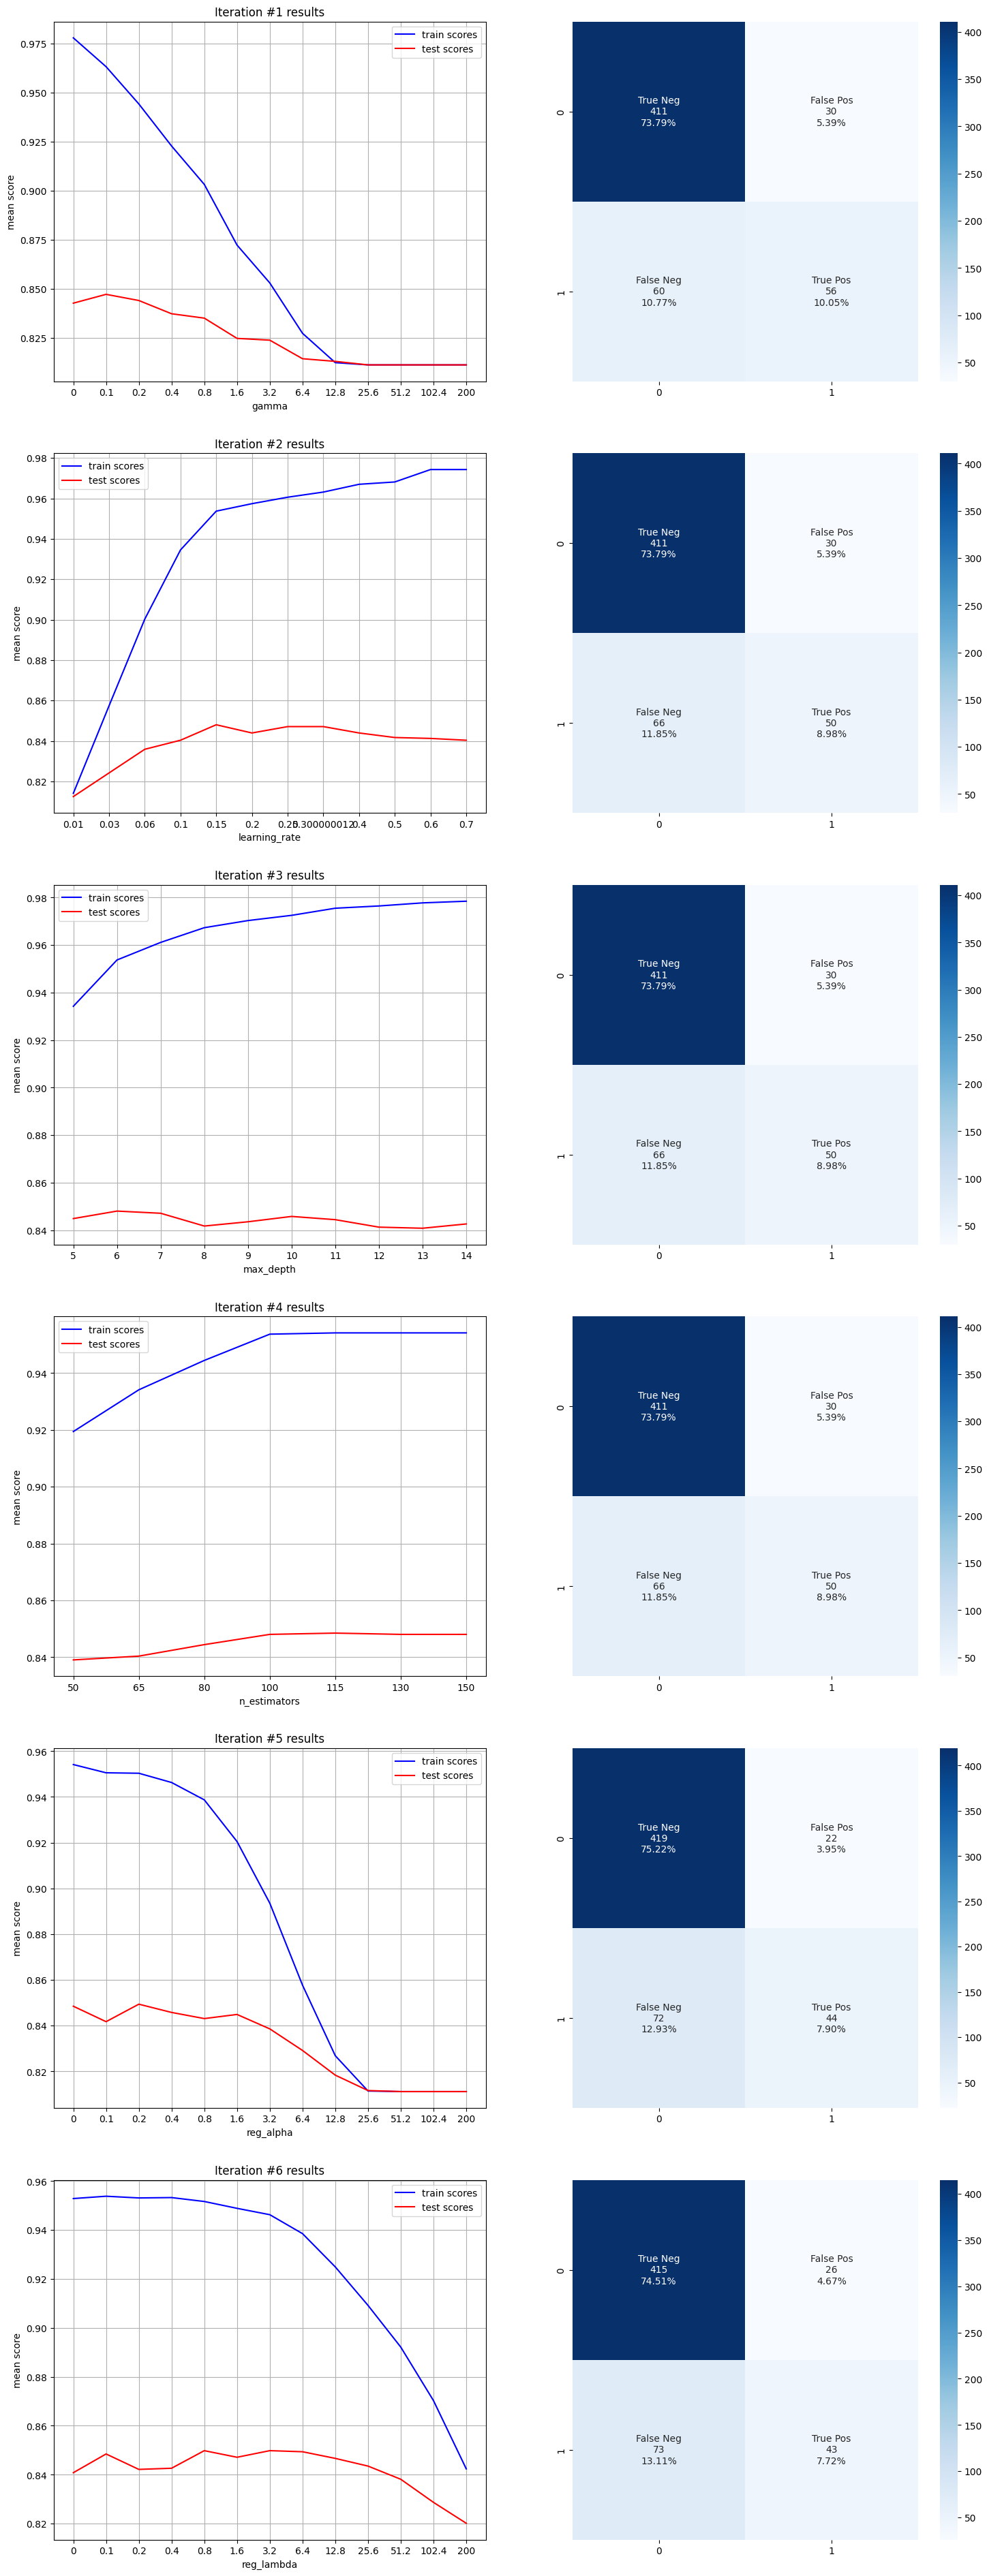

In [26]:
#plot ROC_AUC and confusion matrix for xgbc (maccs fp) model on train and test set
plots_for_model()

### Train new model on best hyperparameters

In [ ]:
best_params = {}

In [29]:
for i, model in enumerate(model_results):
    if model != 'xgbc0':
        best_params[list(param_grid.keys())[i-1]]=model_results[model]['best_params'][list(param_grid.keys())[i-1]]

In [30]:
print(best_params)

{'gamma': 0.1, 'learning_rate': 0.15, 'max_depth': 6, 'n_estimators': 115, 'reg_alpha': 0.2, 'reg_lambda': 3.2}


In [35]:
#add best params to grid search parameter
for key in best_params:
    params[key]=[best_params[key]]

In [ ]:
crossvalidation('opti_clf', static_train_x, static_test_x, static_train_y, 
    static_test_y, best_params, params, iterable_parameter=np.nan)

### Model Performance on Test Set

In [42]:
acc = model_results["opti_clf"]["test_accuracy"]
sens = model_results["opti_clf"]["test_sensitivity"]
spec = model_results["opti_clf"]["test_specificity"]
f1 = model_results["opti_clf"]["test F1-score label 1"]
roc_auc = model_results["opti_clf"]["test roc auc score"]

# Print performance results
print(f"Accuracy: {acc:.2}")
print(f"Sensitivity: {sens:.2f}")
print(f"Specificity: {spec:.2f}")
print(f"F1: {f1:.2f}")
print(f"AUC: {roc_auc:.2f}")

Accuracy: 0.82
Sensitivity: 0.62
Specificity: 0.37
F1: 0.46
AUC: 0.86


In [64]:
#extract model with best hyperparameters
xgb_model = model_results['opti_clf']["classifier"]

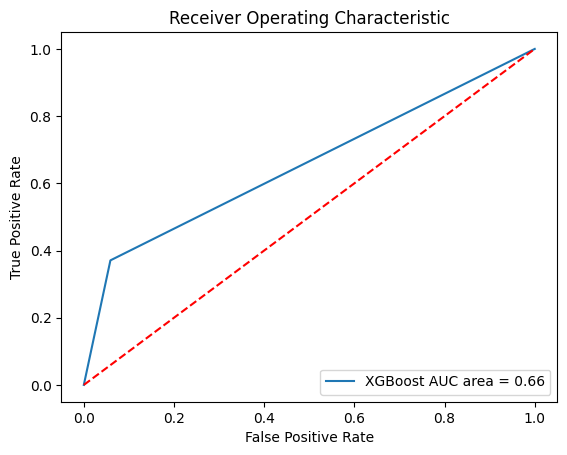

In [60]:
plot_roc_curves_for_models({"XGBoost":xgb_model},static_test_x,static_test_y)

### Save Model

In [65]:
# Save as pickle
file_name = "../models/XGBoost/checkpoints/xgb_best.pkl"

# save
pickle.dump(xgb_model, open(file_name, "wb"))